### This notebook has the analysis os learning curves during SEFLa sessions. 
4/26/2022 GT

In [ ]:
#installing a stat package
!pip install pingouin

In [ ]:
from os.path import join
import sys
import glob

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import pingouin as pg

# for slope calculation
from scipy.stats import linregress

sns.set(font_scale = 1.5)
sns.set_context('talk')
# sns.set_style("white")


%matplotlib inline

In [ ]:
sns.set_context

In [ ]:
from google.colab import auth
auth.authenticate_user()

import gspread
from google.auth import default
creds, _ = default()

gc = gspread.authorize(creds)

from google.colab import drive
drive.mount('/content/drive')

save_dir = '/content/drive/Shareddrives/TuriLab/Data/PTSD_project/!analysis/saveFolder/'

Mounted at /content/drive


In [ ]:
df = pd.read_csv(join(save_dir,'els_and_age_matched_mice.csv'))
df.head(2)
# df.info()

#optional line. it will remove the "pre" column,
# i.e. the before shock freezing

,Unnamed: 0,group,els,sex,genotype,pre,shock01,shock02,shock03,shock04,shock05,shock06,shock07,shock08,shock09,shock10,cohort_id
0,87,Control,y,Male,wt,11.8,28.41,12.37,55.32,8.09,9.15,1.31,3.06,48.64,98.73,95.07,els1_922-1
1,88,Control,y,Male,wt,0.0,0.00,0.18,0.00,1.40,1.08,1.89,5.81,0.63,7.70,53.19,els1_922-2


Selecting ELS mice and making groups with equal number of 

In [ ]:
df_sefl = df[df['group']=='SEFL']
print(df_sefl.groupby('els')['cohort_id'].nunique())
print('===================\n')
# df_sefl.head()
print(f'equalized groups')
df_equal = pd.concat([df_sefl[df_sefl['els']=='n'],
                      df_sefl[df_sefl['els']=='y'].sample(n=13, random_state=3)])
df_equal.groupby(['els'])['cohort_id'].nunique()

els
n    13
y    14
Name: cohort_id, dtype: int64

equalized groups


els
n    13
y    13
Name: cohort_id, dtype: int64

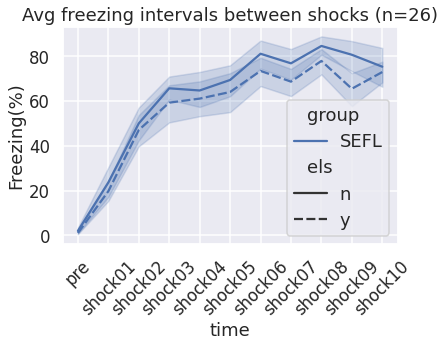

In [ ]:
melted_df = pd.melt(df_equal,
                    id_vars=['cohort_id', 'group', 'sex', 'genotype', 
                                       'els'],
                    value_vars=df.columns[4:-1],
                    var_name='time' )

# renaming one column
melted_df.rename(columns={0: "condition", 'value': 'Freezing(%)'},
                 inplace=True)
# melted_df.tail(4)
g = sns.lineplot(data=melted_df, x='time', y='Freezing(%)',
             hue='group', style='els')
plt.xticks(rotation=45)
num_mice = melted_df['cohort_id'].nunique()
# print(num_mice)
plt.title('Avg freezing intervals between shocks (n={})'.format(num_mice))
# plt.savefig(join(save_dir, 'ELS_nonELS_freezing.png'), transparent=True,
#             dpi=300, bbox_inches="tight")

In [ ]:
# using shock06 as a second time point
df_equal['x'] = df_equal.apply(lambda row: [0.0,100.0], axis=1)
df_equal['y'] = df_equal.apply(lambda row: [row.pre, row.shock06], axis=1)
# calculating slopes
df_equal['slope_pre_shock06'] = df_equal.apply(lambda row: linregress(row.x, row.y)[0], axis=1)
df_equal.head(2)

,Unnamed: 0,group,els,sex,genotype,pre,shock01,shock02,shock03,shock04,shock05,shock06,shock07,shock08,shock09,shock10,cohort_id,x,y,slope_pre_shock06
8,95,SEFL,n,Male,wt,1.10,27.37,57.65,80.66,71.81,69.32,90.93,50.00,84.50,80.78,80.02,els1_939-1,"[0.0, 100.0]","[1.1, 90.93]",0.8983
9,96,SEFL,n,Male,wt,9.71,46.49,58.63,56.15,63.63,75.46,84.73,55.61,82.73,85.56,70.52,els1_939-2,"[0.0, 100.0]","[9.71, 84.73]",0.7502


    cohort_id group   sex els           variable   slope
0  els1_939-1  SEFL  Male   n  slope_pre_shock06  0.8983
1  els1_939-2  SEFL  Male   n  slope_pre_shock06  0.7502


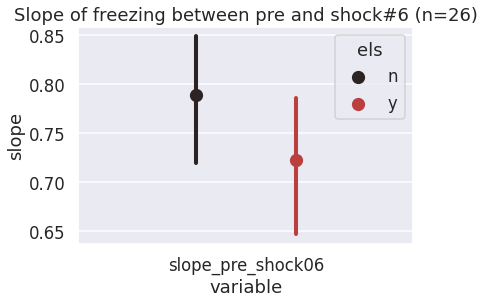

In [ ]:
melted_df = pd.melt(df_equal,
                    id_vars=['cohort_id', 'group', 'sex','els'],
                    value_vars='slope_pre_shock06',
                    value_name='slope')
print(melted_df.head(2))
g = sns.pointplot(data=melted_df, x='variable', y='slope', hue='els',
              dodge=0.3, color='#bb3f3f')
num_mice = melted_df['cohort_id'].nunique()
g.set_title('Slope of freezing between pre and shock#6 (n={})'.format(num_mice))
# plt.savefig(join(save_dir, 'slope_freezing_ELS.png'), transparent=True,
#             dpi=300, bbox_inches="tight")

Running independent two-sample T-test with unequal sample size

In [ ]:
pg.ttest(melted_df[melted_df['els'] == 'n']['slope'],
         melted_df[melted_df['els'] == 'y']['slope'])

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,1.362506,24,two-sided,0.185688,"[-0.03, 0.17]",0.534419,0.713,0.257846
